# Table of Contents
* [Submitting HITs](#Submitting-HITs)
	* [load dataset](#load-dataset)
	* [building html](#building-html)
		* [code](#code)
		* [running test](#running-test)
	* [Building URLs for images on s3](#Building-URLs-for-images-on-s3)
	* [submitting HITs in groups](#submitting-HITs-in-groups)
		* [creates HITs, careful with this one](#creates-HITs,-careful-with-this-one)
* [Reviewing latest HITs](#Reviewing-latest-HITs)
	* [download](#download)
	* [process](#process)
* [Merging latest round of HITs into combined dataset](#Merging-latest-round-of-HITs-into-combined-dataset)
	* [Load previously pickled results](#Load-previously-pickled-results)
	* [Load prior complete dataset if not in memory](#Load-prior-complete-dataset-if-not-in-memory)
	* [Updating full dataset](#Updating-full-dataset)
	* [Working with full dataset](#Working-with-full-dataset)
* [Worker analysis](#Worker-analysis)
	* [Basic worker stats](#Basic-worker-stats)
		* [HIT duration for pricing](#HIT-duration-for-pricing)
	* [Identifying high and low consensus workers](#Identifying-high-and-low-consensus-workers)
	* [Messaging workers](#Messaging-workers)
* [HIT end-of-life](#HIT-end-of-life)
	* [Pickle latest results](#Pickle-latest-results)
	* [Pickle combined dataset](#Pickle-combined-dataset)
	* [Accepting and deleting HITs... careful with these](#Accepting-and-deleting-HITs...-careful-with-these)
* [End](#End)


In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light default
plt.rcParams['figure.figsize'] = (16.0, 10.0)

import re
from datetime import datetime
import dateutil.parser as dt_parse
import pickle
import boto
from copy import deepcopy
import json
import os
import jinja2
from IPython.core.display import HTML

import boto.mturk.connection as tc
import boto.mturk.question as tq
from boto.mturk.qualification import PercentAssignmentsApprovedRequirement, Qualifications, Requirement

from keysTkingdom import mturk_ai2
from keysTkingdom import aws_tokes
from keysTkingdom import mturk_aristo


# import pdfextraction.amt_boto_modules as amt_util
# from tqa_utils import Evaluator

# Submitting HITs

cost estimate

In [2]:
cost_per_hit = 0.02
n_turkers_per_hit = 3
n_hits_per_video = 3

n_videos_low = 1000
n_videos_high = 50000

low = cost_per_hit * n_turkers_per_hit * n_videos_low * n_hits_per_video
high = cost_per_hit * n_turkers_per_hit * n_videos_high * n_hits_per_video
print(str(low) + ' - $' + str(high))

180.0 - $9000.0


## building html

### code

In [3]:
import os
import jinja2
import argparse

j2env = jinja2.Environment()

In [4]:
from boto.mturk.connection import MTurkConnection
from boto.mturk.qualification import *
from jinja2 import Environment, FileSystemLoader

## Building hits from files

In [218]:
import os
import random

gif_dir = '/Users/schwenk/wrk/animation_gan/data/test_task/'
episode = '/s_03_e_22'
gif_files = os.listdir(gif_dir)

test_gifs = [os.path.join(episode, fn) for fn in random.sample(gif_files, 1)]

## submitting HITs in groups

In [27]:
# ## Switch between sandbox and the real world here ##
# ## DON'T FORGET to change submission POST request in the client ##

# sandbox_host = 'mechanicalturk.sandbox.amazonaws.com' 
# real_world_host = 'mechanicalturk.amazonaws.com'
# mturk = tc.MTurkConnection(
#     aws_access_key_id = mturk_ai2.access_key,
#     aws_secret_access_key = mturk_ai2.access_secret_key,
#     host = sandbox_host,
#     debug = 1 # debug = 2 prints out all requests.
# )
# current_account_balance = mturk.get_account_balance()[0]
# print(current_account_balance) # a reminder of sandbox

### html

In [135]:
bb_html = """
<div style="display:none;">
href="https://ajax.googleapis.com/ajax/libs/jqueryui/1.10.3/themes/smoothness/jquery-ui.css" rel="stylesheet" />
<script src="https://ajax.googleapis.com/ajax/libs/jquery/1.9.1/jquery.min.js"></script>
<script src="https://ajax.googleapis.com/ajax/libs/jqueryui/1.10.3/jquery-ui.js"></script>
<script type='text/javascript' src='https://s3.amazonaws.com/mturk-public/externalHIT_v1.js'></script>

</div>

<div style="display:inline-block;vertical-align:top;">
  <h1>Annotate objects in the picture</h1>
  <p>
    Draw a rectangle over an object with mouse. Then, name that object.
  </p>
  <div>
    <label for="comment"><em>Comment:</em></label><br />
    <textarea id="comment_area" name="comment"></textarea>
  </div>
  <p id="button_paragraph">
    <input id="annotation_data" name="annotation_data" type="hidden" />
    <input id="reset_button" type="reset" />
  </p>
</div>
<div id="bbox_annotator" style="display:inline-block"></div>

<script type="text/javascript">
(function() {
  var BBoxSelector;

  BBoxSelector = (function() {

    function BBoxSelector(image_frame, options) {
      if (options == null) {
        options = {};
      }
      options.input_method || (options.input_method = "text");
      this.image_frame = image_frame;
      this.border_width = options.border_width || 2;
      this.selector = $('<div class="bbox_selector"></div>');
      this.selector.css({
        "border": this.border_width + "px dotted rgb(127,255,127)",
        "position": "absolute"
      });
      this.image_frame.append(this.selector);
      this.selector.css({
        "border-width": this.border_width
      });
      this.selector.hide();
      this.create_label_box(options);
    }

    BBoxSelector.prototype.create_label_box = function(options) {
      var label, _i, _len, _ref;
      options.labels || (options.labels = ["object"]);
      this.label_box = $('<div class="label_box"></div>');
      this.label_box.css({
        "position": "absolute"
      });
      this.image_frame.append(this.label_box);
      switch (options.input_method) {
        case 'select':
          if (typeof options.labels === "string") {
            options.labels = [options.labels];
          }
          this.label_input = $('<select class="label_input" name="label"></select>');
          this.label_box.append(this.label_input);
          this.label_input.append($('<option value>choose an item</option>'));
          _ref = options.labels;
          for (_i = 0, _len = _ref.length; _i < _len; _i++) {
            label = _ref[_i];
            this.label_input.append('<option value="' + label + '">' + label + '</option>');
          }
          this.label_input.change(function(e) {
            return this.blur();
          });
          break;
        case 'text':
          if (typeof options.labels === "string") {
            options.labels = [options.labels];
          }
          this.label_input = $('<input class="label_input" name="label" ' + 'type="text" value>');
          this.label_box.append(this.label_input);
          this.label_input.autocomplete({
            source: options.labels || [''],
            autoFocus: true
          });
          break;
        case 'fixed':
          if ($.isArray(options.labels)) {
            options.labels = options.labels[0];
          }
          this.label_input = $('<input class="label_input" name="label" type="text">');
          this.label_box.append(this.label_input);
          this.label_input.val(options.labels);
          break;
        default:
          throw 'Invalid label_input parameter: ' + options.input_method;
      }
      return this.label_box.hide();
    };

    BBoxSelector.prototype.crop = function(pageX, pageY) {
      var point;
      return point = {
        x: Math.min(Math.max(Math.round(pageX - this.image_frame.offset().left), 0), Math.round(this.image_frame.width() - 1)),
        y: Math.min(Math.max(Math.round(pageY - this.image_frame.offset().top), 0), Math.round(this.image_frame.height() - 1))
      };
    };

    BBoxSelector.prototype.start = function(pageX, pageY) {
      this.pointer = this.crop(pageX, pageY);
      this.offset = this.pointer;
      this.refresh();
      this.selector.show();
      $('body').css('cursor', 'crosshair');
      return document.onselectstart = function() {
        return false;
      };
    };

    BBoxSelector.prototype.update_rectangle = function(pageX, pageY) {
      this.pointer = this.crop(pageX, pageY);
      return this.refresh();
    };

    BBoxSelector.prototype.input_label = function(options) {
      $('body').css('cursor', 'default');
      document.onselectstart = function() {
        return true;
      };
      this.label_box.show();
      return this.label_input.focus();
    };

    BBoxSelector.prototype.finish = function(options) {
      var data;
      this.label_box.hide();
      this.selector.hide();
      data = this.rectangle();
      data.label = $.trim(this.label_input.val().toLowerCase());
      if (options.input_method !== 'fixed') {
        this.label_input.val('');
      }
      return data;
    };

    BBoxSelector.prototype.rectangle = function() {
      var rect, x1, x2, y1, y2;
      x1 = Math.min(this.offset.x, this.pointer.x);
      y1 = Math.min(this.offset.y, this.pointer.y);
      x2 = Math.max(this.offset.x, this.pointer.x);
      y2 = Math.max(this.offset.y, this.pointer.y);
      return rect = {
        left: x1,
        top: y1,
        width: x2 - x1 + 1,
        height: y2 - y1 + 1
      };
    };

    BBoxSelector.prototype.refresh = function() {
      var rect;
      rect = this.rectangle();
      this.selector.css({
        left: (rect.left - this.border_width) + 'px',
        top: (rect.top - this.border_width) + 'px',
        width: rect.width + 'px',
        height: rect.height + 'px'
      });
      return this.label_box.css({
        left: (rect.left - this.border_width) + 'px',
        top: (rect.top + rect.height + this.border_width) + 'px'
      });
    };

    BBoxSelector.prototype.get_input_element = function() {
      return this.label_input;
    };

    return BBoxSelector;

  })();

  this.BBoxAnnotator = (function() {

    function BBoxAnnotator(options) {
      var annotator, image_element;
      annotator = this;
      this.annotator_element = $(options.id || "#bbox_annotator");
      this.border_width = options.border_width || 2;
      this.show_label = options.show_label || (options.input_method !== "fixed");
      this.image_frame = $('<div class="image_frame"></div>');
      this.annotator_element.append(this.image_frame);
      image_element = new Image();
      image_element.src = options.url;
      image_element.onload = function() {
        options.width || (options.width = image_element.width);
        options.height || (options.height = image_element.height);
        annotator.annotator_element.css({
          "width": (options.width + annotator.border_width * 2) + 'px',
          "height": (options.height + annotator.border_width * 2) + 'px',
          "cursor": "crosshair"
        });
        annotator.image_frame.css({
          "background-image": "url('" + image_element.src + "')",
          "width": options.width + "px",
          "height": options.height + "px",
          "position": "relative"
        });
        annotator.selector = new BBoxSelector(annotator.image_frame, options);
        return annotator.initialize_events(annotator.selector, options);
      };
      image_element.onerror = function() {
        return annotator.annotator_element.text("Invalid image URL: " + options.url);
      };
      this.entries = [];
      this.onchange = options.onchange;
    }

    BBoxAnnotator.prototype.initialize_events = function(selector, options) {
      var annotator, status;
      status = 'free';
      this.hit_menuitem = false;
      annotator = this;
      this.annotator_element.mousedown(function(e) {
        if (!annotator.hit_menuitem) {
          switch (status) {
            case 'free':
            case 'input':
              if (status === 'input') {
                selector.get_input_element().blur();
              }
              if (e.which === 1) {
                selector.start(e.pageX, e.pageY);
                status = 'hold';
              }
          }
        }
        annotator.hit_menuitem = false;
        return true;
      });
      $(window).mousemove(function(e) {
        switch (status) {
          case 'hold':
            selector.update_rectangle(e.pageX, e.pageY);
        }
        return true;
      });
      $(window).mouseup(function(e) {
        switch (status) {
          case 'hold':
            selector.update_rectangle(e.pageX, e.pageY);
            selector.input_label(options);
            status = 'input';
            if (options.input_method === 'fixed') {
              selector.get_input_element().blur();
            }
        }
        return true;
      });
      selector.get_input_element().blur(function(e) {
        var data;
        switch (status) {
          case 'input':
            data = selector.finish(options);
            if (data.label) {
              annotator.add_entry(data);
              if (annotator.onchange) {
                annotator.onchange(annotator.entries);
              }
            }
            status = 'free';
        }
        return true;
      });
      selector.get_input_element().keypress(function(e) {
        switch (status) {
          case 'input':
            if (e.which === 13) {
              selector.get_input_element().blur();
            }
        }
        return e.which !== 13;
      });
      selector.get_input_element().mousedown(function(e) {
        return annotator.hit_menuitem = true;
      });
      selector.get_input_element().mousemove(function(e) {
        return annotator.hit_menuitem = true;
      });
      selector.get_input_element().mouseup(function(e) {
        return annotator.hit_menuitem = true;
      });
      return selector.get_input_element().parent().mousedown(function(e) {
        return annotator.hit_menuitem = true;
      });
    };

    BBoxAnnotator.prototype.add_entry = function(entry) {
      var annotator, box_element, close_button, text_box;
      this.entries.push(entry);
      box_element = $('<div class="annotated_bounding_box"></div>');
      box_element.appendTo(this.image_frame).css({
        "border": this.border_width + "px solid rgb(127,255,127)",
        "position": "absolute",
        "top": (entry.top - this.border_width) + "px",
        "left": (entry.left - this.border_width) + "px",
        "width": entry.width + "px",
        "height": entry.height + "px",
        "color": "rgb(127,255,127)",
        "font-family": "monospace",
        "font-size": "small"
      });
      close_button = $('<div></div>').appendTo(box_element).css({
        "position": "absolute",
        "top": "-8px",
        "right": "-8px",
        "width": "16px",
        "height": "0",
        "padding": "16px 0 0 0",
        "overflow": "hidden",
        "color": "#fff",
        "background-color": "#030",
        "border": "2px solid #fff",
        "-moz-border-radius": "18px",
        "-webkit-border-radius": "18px",
        "border-radius": "18px",
        "cursor": "pointer",
        "-moz-user-select": "none",
        "-webkit-user-select": "none",
        "user-select": "none",
        "text-align": "center"
      });
      $("<div></div>").appendTo(close_button).html('×').css({
        "display": "block",
        "text-align": "center",
        "width": "16px",
        "position": "absolute",
        "top": "-2px",
        "left": "0",
        "font-size": "16px",
        "line-height": "16px",
        "font-family": '"Helvetica Neue", Consolas, Verdana, Tahoma, Calibri, ' + 'Helvetica, Menlo, "Droid Sans", sans-serif'
      });
      text_box = $('<div></div>').appendTo(box_element).css({
        "overflow": "hidden"
      });
      if (this.show_label) {
        text_box.text(entry.label);
      }
      annotator = this;
      box_element.hover((function(e) {
        return close_button.show();
      }), (function(e) {
        return close_button.hide();
      }));
      close_button.mousedown(function(e) {
        return annotator.hit_menuitem = true;
      });
      close_button.click(function(e) {
        var clicked_box, index;
        clicked_box = close_button.parent(".annotated_bounding_box");
        index = clicked_box.prevAll(".annotated_bounding_box").length;
        clicked_box.detach();
        annotator.entries.splice(index, 1);
        return annotator.onchange(annotator.entries);
      });
      return close_button.hide();
    };

    BBoxAnnotator.prototype.clear_all = function(e) {
      $(".annotated_bounding_box").detach();
      this.entries.splice(0);
      return this.onchange(this.entries);
    };

    return BBoxAnnotator;

  })();

}).call(this);

// Main entry point. Use a placeholder for image urls.
$(document).ready(function() {
  var assignment_id = turkGetParam('assignmentId', "");
  // Initialize the bounding-box annotator.
  var annotator = new BBoxAnnotator({
n    input_method: 'text', // Can be one of ['text', 'select', 'fixed']
    labels: ["dress", "top", "skirt", "pants", "shoes"], // Label of the object.
    onchange: function(entries) {
      $("#annotation_data").val(JSON.stringify(entries));
      if (entries.length > 0 &&
          assignment_id != "" &&
          assignment_id != "ASSIGNMENT_ID_NOT_AVAILABLE") {
        $("#submitButton").removeAttr("disabled");
      }
      else {
        $("#submitButton").attr("disabled", "disabled");
      }
    }
  });
  // Initialize the reset button.
  $("#reset_button").click(function(e) {
    annotator.clear_all();
  });
  // Disable the submission at the beginning.
  $("#submitButton").attr("disabled", "disabled");
  $("#submitButton").detach().appendTo("#button_paragraph");
  if (assignment_id == "ASSIGNMENT_ID_NOT_AVAILABLE") {
    $("#submitButton").val("This is preview");
  }
  console.log(assignment_id);
});
</script>

"""

### new code

In [207]:
page_html = generate_task_page(s3_base_path, test_still)

In [219]:
test_still

's_01_e_26_shot_006556_006630_10.png'

In [281]:
def generate_task_page(s3_base_path, img_id, template_file='character_bbox.html'):
    env = Environment(loader=FileSystemLoader('hit_templates'))
    template = env.get_template(template_file)
    html_dir = './html_renders' 
    html_out_file = os.path.join(html_dir, 'char_bbox.html')
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
    page_html =  template.render(s3_uri_base = s3_base_path, image_id=img_id)
    
    with open(html_out_file, 'w') as f:
        f.write(page_html.encode('ascii', 'ignore').decode('utf-8'))
        
    return page_html

# def make_image_list_str(images):
#     images = [images]
#     s3_base = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/scene_gifs'
#     return ', '.join(['\'' + s3_base + img + '\'' for img in images])

## hide

In [105]:
def get_completed_hits(mturk_connection):
    """
    Queries amt for all active user HITs.
    :param mturk_connection: active mturk connection established by user in the nb.
    :return: list of boto HIT result objects
    """
    reviewable_hits = []
    page_n = 1
    hits_left = True
    while hits_left:
        hit_range = mturk_connection.get_reviewable_hits(page_size=100, page_number=page_n)
        if not hit_range:
            hits_left = False
            break
        reviewable_hits.extend(hit_range)
        page_n += 1
    return reviewable_hits


def get_assignments(mturk_connection, reviewable_hits, status=None):
    """
    Retrieves individual assignments associated with the specified HITs.
    :param mturk_connection: active mturk connection established by user in the nb.
    :param reviewable_hits: HITs to review
    :param status: HIT status to filter by.
    :return: hit_id:assignment dict
    """
    assignments = defaultdict(list)
    for hit in reviewable_hits:
        assignment = mturk_connection.get_assignments(hit.HITId, status=status)
        assignments[hit.HITId].extend(assignment)
    return assignments

In [106]:
def build_hit_params(qhtml, static_params):
    """
    Dynamically builds some HIT params that will change based on the book/url
    :param url: formatted url of page image on s3
    :param static_params: Universal HIT params (set by user in notebook).
    :return: complete HIT parameters.
    """
    import copy
    import boto
    def build_qualifications():
        """
        Creates a single qualification that workers have a > 95% acceptance rate.
        :return: boto qualification obj.
        """
        qualifications = Qualifications()
        req1 = PercentAssignmentsApprovedRequirement(comparator="GreaterThan", integer_value="95")
        qualifications.add(req1)
        return qualifications
    
    hit_params = copy.deepcopy(static_params)
    hit_params['qualifications'] = build_qualifications()
    hit_params['reward'] = boto.mturk.price.Price(hit_params['amount'])
    hit_params['html']= qhtml
    return hit_params

In [210]:
def prepare_hit(s3_base_path, img_uri, static_parameters):
    question_html = generate_task_page(s3_base_path, img_uri)
    return build_hit_params(question_html, static_params)

## run

In [339]:
static_params = {
    'title': "Annotate characters from an animation frame",
    'description': "Draw bounding boxes and label characters appearing in a image",
    'keywords': ['animation', 'image', 'bounding box', 'image annotation'],
    'frame_height': 1000,
    'amount': 0.05,
    'duration': 3600 * 1,
    'lifetime': 3600 * 24 * 2,
    'max_assignments': 1,
}

In [338]:
build_hit_group = [prepare_hit(s3_base_path, still, static_params) for still in stills_to_annotate]

In [333]:
hit_group = [amt_con.create_html_hit(single_hit) for single_hit in build_hit_group]

## load dataset

In [141]:
s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/still_frames/'

In [146]:
test_still = 's_01_e_26_shot_006556_006630_10.png'

In [229]:
# build_hit_group

In [345]:
with open('../../build_dataset/skeleton_dataset.json', 'r') as f:
    ds_skeleton = json.load(f)

In [373]:
stills_to_annotate = []
for clip in ds_skeleton[0:200]:
    for still in clip['keyFrames']:
        stills_to_annotate.append(still)

## submit

In [11]:
from mturk import MTurk

In [356]:
turk_account = mturk_ai2
rw_host='mechanicalturk.amazonaws.com'
amt_con = MTurk(turk_account.access_key, turk_account.access_secret_key, host=rw_host)
amt_con.get_account_balance()

$2,003.07

In [376]:
static_params = {
    'title': "Annotate characters from an animation frame",
    'description': "Draw bounding boxes and label characters appearing in a image",
    'keywords': ['animation', 'image', 'bounding box', 'image annotation'],
    'frame_height': 1000,
    'amount': 0.05,
    'duration': 3600 * 1,
    'lifetime': 3600 * 24 * 2,
    'max_assignments': 3,
}

In [358]:
# build_hit_group = [prepare_hit(gif, static_params) for gif in test_gifs]

In [374]:
build_hit_group = [prepare_hit(s3_base_path, still, static_params) for still in stills_to_annotate]

In [375]:
len(build_hit_group)

600

In [371]:
200 * 3 *3 * 0.05

90.0

In [377]:
stage_1_batch_1_200 = [amt_con.create_html_hit(single_hit) for single_hit in build_hit_group]

In [382]:
len(stage_1_batch_1_200)

600

In [340]:
# amt_con.delete_all_hits()

## review

In [466]:
complete_hits = get_completed_hits(amt_con.connection)

In [467]:
results = get_assignments(amt_con.connection, complete_hits)

In [560]:
def create_result(assmt):
    result = json.loads(assmt.answers[0][0].fields[0])
    result['h_id'] = assmt.HITId
    return result

In [468]:
assignments =[]
for assignment_triple in list(results.values()):
    assignments.extend(assignment_triple)

In [583]:
assignment_results = [create_result(ar) for ar in assignments]

In [584]:
characters_present = [{'h_id': anno['h_id'], 'still_id': anno['stillID'], 'characters': set([ch['label'] for ch in json.loads(anno['characterBoxes'])])} for anno in assignment_results]

In [432]:
ta1 = list(results.values())[0][0]
ta2 = list(results.values())[0][1]

In [436]:
ta1.answers[0]

In [395]:
amt_con.get_results_dict(assignments[:1])

[{'HIT_id': u'371DNNCG452HFL6W6LLWMNUS70O8TA',
  'answers': {u'output': [u'{"stillID":"s_01_e_26_shot_020977_021051_70.png","characterBoxes":"[{\\"left\\":319,\\"top\\":166,\\"width\\":258,\\"height\\":227,\\"label\\":\\"no characters\\"}]"}']},
  'assignment_object': <boto.mturk.connection.Assignment at 0x113c17910>,
  'worker_Id': u'A3BUSRXW32A27S'}]

In [315]:
# with open('my_test.json', 'w') as f:
#     json.dump(assignment_results, f)

In [381]:
len(complete_hits)

546

In [667]:
main_characters =  {"fred",
             "barney",
              "wilma",
              "betty",
              "pebbles",
              "bamm bamm",
              "dino",
              "mr slate",
              "baby puss",
              "hoppy",
              "no characters"}

In [672]:
def all_main(char_set, main_chars=main_characters):
    return not bool(char_set.difference(main_chars))

In [683]:
char_df = pd.DataFrame(characters_present)

In [684]:
char_df['all_main'] = char_df['characters'].apply(lambda x: all_main(x))

In [782]:
all_chars = [c for char_list in char_df['characters'].apply(lambda x: list(x)).tolist() for c in char_list]
char_counts = pd.Series(all_chars).value_counts()

In [871]:
# char_counts.hist(bins = 30, log=True)

In [853]:
n=20
char_counts[n:n+30]

boy with blue dress                                    2
police officer with moustache                          2
man with blue dress                                    2
police office                                          2
man with police dress                                  2
play boy                                               2
boy with yellow hair                                   2
business man                                           1
man in blue                                            1
man with voilet dress and cap                          1
poice officer                                          1
friend                                                 1
blonde boy                                             1
a girl                                                 1
kitten                                                 1
hat man                                                1
fred and barney looking at something interestingly.    1
barney and fred pulling a troph

In [694]:
grouped_by_still = char_df.groupby('still_id')

In [695]:
agg_df = grouped_by_still.aggregate(len)

In [696]:
import scipy

In [697]:
agged_on_mode = grouped_by_still.agg(lambda x: scipy.stats.mode(x))
consensus_results_df = agged_on_mode.reset_index()

In [705]:
consensus_results_df['mode_count'] = consensus_results_df['characters'].apply(lambda x: x[1][0])

In [824]:
consensus_results_df['all_agree'] = consensus_results_df['mode_count'] == 3
consensus_results_df['two_agree'] = consensus_results_df['mode_count'] == 2

In [839]:
char_df.shape[0] / 3 /3

187.0

In [831]:
consensus_results_df[agree_all_main].shape

(486, 7)

In [825]:
consensus_results_df['two_agree'].value_counts()

False    410
True     150
Name: two_agree, dtype: int64

In [838]:
consensus_results_df[agree_all_main]['characters'].apply(lambda x: x[1][0]).value_counts()

3    333
2    127
1     26
Name: characters, dtype: int64

In [842]:
not_main =set(consensus_results_df[~agree_all_main]['still_id'].tolist())

In [846]:
not_main_df = char_df[char_df['still_id'].isin(not_main)]

In [847]:
not_main_df

,characters,h_id,still_id,all_main
0,{no characters},371DNNCG452HFL6W6LLWMNUS70O8TA,s_01_e_26_shot_020977_021051_70.png,True
1,{bamm bamm},371DNNCG452HFL6W6LLWMNUS70O8TA,s_01_e_26_shot_020977_021051_70.png,True
2,"{no character, no characters}",371DNNCG452HFL6W6LLWMNUS70O8TA,s_01_e_26_shot_020977_021051_70.png,False
48,"{police officer with moustache, police officer...",3FJ2RVH2506N9RVTSY7ELWGDRTT291,s_01_e_03_shot_034059_034133_40.png,False
49,{fred},3FJ2RVH2506N9RVTSY7ELWGDRTT291,s_01_e_03_shot_034059_034133_40.png,True
50,"{no characters, fred}",3FJ2RVH2506N9RVTSY7ELWGDRTT291,s_01_e_03_shot_034059_034133_40.png,True
120,"{police, police officer}",3DW3BNF1GIIWSDALBGLBN5ID4L48VQ,s_01_e_26_shot_028469_028543_40.png,False
121,{no characters},3DW3BNF1GIIWSDALBGLBN5ID4L48VQ,s_01_e_26_shot_028469_028543_40.png,True
122,{police officer},3DW3BNF1GIIWSDALBGLBN5ID4L48VQ,s_01_e_26_shot_028469_028543_40.png,False
144,{no characters},3HRWUH63QV20XQIABRSH14E9GS1N5M,s_01_e_15_shot_018392_018466_40.png,True


In [708]:
consensus_results_df.head(1)

,still_id,characters,h_id,all_main,mode_count,all_agree
0,s_01_e_02_shot_001452_001526_10.png,"([{mr slate}], [1])","([33P2GD6NROSB5DH2FG1AY90VR6NHKS], [3])","([False], [2])",1,False


In [826]:
agree_all_main = consensus_results_df['all_main'].apply(lambda x: x[1][0]) == 3 

In [739]:
all_agree = consensus_results_df[agree_all_main][consensus_results_df[agree_all_main]['all_agree']]
disagree = consensus_results_df[agree_all_main][~consensus_results_df[agree_all_main]['all_agree']]

In [745]:
conflict_images = set(disagree['still_id'].tolist())

In [751]:
conflict_df = char_df[char_df['still_id'].isin(conflict_images)]

In [789]:
import PIL.Image as Image
import requests

In [821]:
image_n += 1

In [822]:
conflict_df.iloc[image_n * 9: image_n * 9 + 3]

,characters,h_id,still_id,all_main
162,"{barney, betty}",3909MD9T20HO5HYMO427XTBDRUEFE8,s_01_e_20_shot_036188_036262_10.png,True
163,"{barney, betty}",3909MD9T20HO5HYMO427XTBDRUEFE8,s_01_e_20_shot_036188_036262_10.png,True
164,"{betty, no characters}",3909MD9T20HO5HYMO427XTBDRUEFE8,s_01_e_20_shot_036188_036262_10.png,True


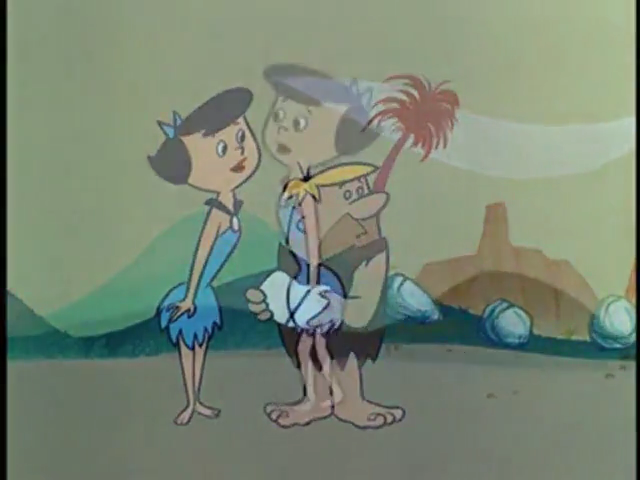

In [823]:
image_url = s3_base_path + conflict_df['still_id'].iloc[image_n *  9]
Image.open(requests.get(image_url, stream=True).raw)

# bounding box clustering

## code 

In [957]:
import numpy as np
from sklearn.cluster import SpectralClustering
import cv2
import PIL.Image as Image
from sklearn.cluster import KMeans


def box_area(box):
    height = box[1][1] - box[0][1]
    width = box[1][0] - box[0][0]
    return height * width

def compute_intersection(b1, b2):
    dx = min(b1[1][0], b2[1][0]) - max(b1[0][0], b2[0][0])
    dy = min(b1[1][1], b2[1][1]) - max(b1[0][1], b2[0][1])
    if (dx >= 0) and (dy >= 0):
        intersection_area = dx * dy
        return intersection_area
    else:
        return

def comp_boxes_iou(b1, b2):
    b1 = b1.reshape(2, 2)
    b2 = b2.reshape(2, 2)
    b1_area = box_area(b1)
    b2_area = box_area(b2)
    intersection = compute_intersection(b1, b2)
    iou = intersection / (b1_area + b2_area - intersection)
    return iou

def comp_box_center(box):
    return [(box[1][0] + box[0][0]) / 2, (box[1][1] + box[0][1]) / 2]

def pick_consensus(clustered_boxes):
    return [sorted(cluster, key=lambda x: box_area(x))[:1] for cluster in clustered_boxes]
        

def draw_loc_consensus_and_individual(diagram_locs, dest_image_dir = './bbox_renders', bracket=0, results_df=''):
    user_image_lookup = defaultdict(lambda: defaultdict(str))
#     flattened_topic_dir = '/Users/schwenk/wrk/stb/ai2-vision-textbook-dataset/diagrams/turk_data/'
    for diagram_name, text_locs in diagram_locs.items():
        try:
            clustered_text_boxes = cluster_diagram_text_centers(text_locs, 3, bracket)
            consensus_boxes = pick_consensus(clustered_text_boxes)
            image_path = flattened_topic_dir + diagram_name
            drawn_image = draw_clusters(image_path, consensus_boxes)
            cv2.imwrite(os.path.join(dest_image_dir, diagram_name.replace('.png', '_consensus.png')), drawn_image)
            user_boxes = get_boxes_by_user(results_df, diagram_name)
            for idx, boxes in enumerate(user_boxes.values()):
                user_image_lookup[diagram_name][idx + 1] = user_boxes.keys()[idx]
                drawn_image = draw_clusters(image_path, np.array(boxes).reshape(len(boxes), 1))
                cv2.imwrite(os.path.join(dest_image_dir, diagram_name.replace('.png', '_' + str(idx + 1) + '.png')), drawn_image) 
        except AttributeError as e:
            print diagram_name, e
    return user_image_lookup


def cluster_diagram_text_centers(text_rects, n_turkers_assigned = 3, bracket=0):
    text_centers= [comp_box_center(rect) for rect in text_rects]
    remainder = len(text_centers) % n_turkers_assigned
    if not remainder:
        n_clusters = int(len(text_centers) / n_turkers_assigned)
    else:
        if bracket != 'lots':
            bracket_n = int(bracket)
        else:
            bracket_n = 7
        n_clusters = len(text_centers) // n_turkers_assigned + bracket
    text_clusterer = KMeans(n_clusters)
    box_array = np.array(text_centers)
    cluster_assignments = text_clusterer.fit_predict(box_array)
    clustered_boxes = [np.array(text_rects)[cluster_assignments == cluster_n].tolist() for cluster_n in range(n_clusters)]
    return clustered_boxes

def limit_rect(rect, max_x, max_y, border_pad = 2):
        if rect[0][0] < 0:
            rect[0][0] = border_pad
        if rect[0][1] < 0:
            rect[0][1] = border_pad
        if rect[1][0]  > max_x:
            rect[1][0] = max_x - border_pad
        if rect[1][1]  > max_y:
            rect[1][1] = max_y -border_pad
            
def draw_clusters(img_path, clustered_boxes, direction='rows'):
    
    def random_color():
        import random
        return random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    max_height, max_width, channels = image.shape

    for idx, cluster in enumerate(clustered_boxes):
        color = random_color()
        for box in cluster:
            limit_rect(box, max_width, max_height)
            cv2.rectangle(image, tuple(box[0]), tuple(box[1]), color=color, thickness=2)
    return image

def draw_loc_clusters(diagram_locs, dest_image_dir = '/Users/schwenk/wrk/stb/check_clustering_km/', bracket=0):
    flattened_topic_dir = '/Users/schwenk/wrk/stb/ai2-vision-textbook-dataset/diagrams/turk_data/'
    for diagram_name, text_locs in diagram_locs.items():
        try:
            clustered_text_boxes = cluster_diagram_text_centers(text_locs, 3, bracket)
            image_path = flattened_topic_dir + diagram_name
            drawn_image = draw_clusters(image_path, clustered_text_boxes)
            cv2.imwrite(os.path.join(dest_image_dir, diagram_name), drawn_image)
        except OverflowError as e:
            print diagram_name, e

def get_frame_rects(frame_annos):
    rects = []
    for rect in json.loads(frame_annos['characterBoxes']):
        rects.append(rect_from_anno(rect))
    return rects

def rect_from_anno(anno):
    upper_left = [anno['left'], anno['top']]
    upper_right = [upper_left[0] + anno['width'], upper_left[1] + anno['height']]
    return [upper_left, upper_right]

## run

In [966]:
image_base_dir = '/Users/schwenk/wrk/animation_gan/build_dataset/Flintstone_Shots_Selected_Frames/'

In [958]:
test_frame = assignment_results[3:6]

In [961]:
# cluster_diagram_text_centers()

In [963]:
test_rects = [get_frame_rects(anno) for anno in test_frame]

In [964]:
flattened_rects = [item for sublist in test_rects for item in sublist]

box_clusters = cluster_diagram_text_centers(flattened_rects)

In [967]:
still_id = test_frame[0]['stillID']

In [968]:

img_a = draw_clusters(os.path.join(image_base_dir, still_id), box_clusters)

print('test')
Image.fromarray(img_a)

# hide

## Reviewing latest HITs

## download

In [ ]:
r_hits_current_batch = amt_util.get_completed_hits(mturk)

In [ ]:
assignment_results_current_batch = amt_util.get_assignments(mturk, r_hits_current_batch, status='Submitted')

## process

In [ ]:
print 'current assignment statuses'
print amt_util.get_assignment_statuses(assignment_results_current_batch)

In [ ]:
submitted_assignments = defaultdict(list)
for hitid, assignments in assignment_results_current_batch.items():
    for assignment in assignments:
        if assignment.AssignmentStatus == 'Submitted':
            submitted_assignments[hitid].append(assignment)

In [ ]:
assigment_worker_lookup = {}
for hit_id, hit_assignments in submitted_assignments.items():
        for assignment in hit_assignments:
            assigment_worker_lookup[assignment.AssignmentId]  = assignment.WorkerId

In [ ]:
def process_raw_hits(assignments_by_hit):
    mechanical_turk_results = defaultdict(list)
    for hit_id, hit_assignments in assignments_by_hit.items():
        for assignment in hit_assignments:
            for answers in assignment.answers:
                try:
                    q_id = answers[0].fields[0]
                    q_ans = answers[1].fields[0]
                    mechanical_turk_results[hit_id].append({
                        assignment.AssignmentId: {q_id: q_ans.replace('.', '')}}
                    )
                except IndexError as e:
                    print(e, answers[0])
    return mechanical_turk_results

In [ ]:
proc_results = process_raw_hits(submitted_assignments)

In [ ]:
def make_answer_json(assignment_results):
    results = {}
    for hid, assignments in assignment_results.items():
        for assignment in assignments:
            for aid, result in assignment.items():
               results.update(result) 
    results_output = {k: v.replace('.', '') for k,v in results.items()}
    return results_output

In [ ]:
res_json = make_answer_json(proc_results)

In [ ]:
with open('turker_answers.json', 'w') as f:
    json.dump(res_json, f)

In [ ]:
def make_results_df(raw_hit_results):
    col_names = ['qid', 'answer', 'hit_id', 'assignment_id']
    results_df = pd.DataFrame(columns=col_names)
    for hit_id, assignments in raw_hit_results.items():
        for assignment in assignments:
            for a_id, annotation in assignment.items():
                for diagram, rectangles in annotation.items():
                    for box in rectangles:
                        results_df.loc[len(results_df)] = \
                            [diagram, box, hit_id, a_id]
    return results_df

In [ ]:
res_df = make_results_df(proc_results)

In [ ]:
grouped_by_page = res_df.groupby(['qid'])

In [ ]:
def make_consensus_df(results_df, no_consensus_flag):
    grouped_by_page = results_df.groupby('qid')
    aggregated_df = grouped_by_page.agg(pd.DataFrame.mode)
#     aggregated_df.drop([ 'page', 'box_id', 'worker_id'], axis=1, inplace=True)
    aggregated_df = aggregated_df.fillna(no_consensus_flag)
    consensus_results_df = aggregated_df.reset_index()
#     consensus_results_df.drop('level_2', axis=1, inplace=True)
    return consensus_results_df

## Merging latest round of HITs into combined dataset 

## Load previously pickled results

In [ ]:
batch_number = 7

with open('./store_hit_results_metadata/group_' + str(batch_number) + '/hit_info.pkl') as f:
    r_hits_previous_batch = pickle.load(f)
    
with open('./store_hit_results_metadata/group_' + str(batch_number) + '/assignment_info.pkl') as f:
    assignment_results_previous_batch = pickle.load(f)
    
# with open('./store_hit_results_metadata/group_' + str(batch_number) + '/raw_res.pkl') as f:
#     raw_hit_results_previous_batch = pickle.load(f)

In [ ]:
# combined_results_batch = pd.read_pickle(data_pickled_dir + 'complete_df.pkl')
# combined_consensus_batch = pd.read_pickle(data_pickled_dir + 'consensus_df.pkl')

In [ ]:
missing_hits = set(assignment_results_previous_batch.keys()).difference(assignment_results_current_batch.keys())
missing_hits_assignments = {k: v for k, v in assignment_results_previous_batch.items() if k in missing_hits}

## Load prior complete dataset if not in memory

In [ ]:
data_pickled_dir = './store_hit_results_metadata/group_latest_combined/' 

In [ ]:
combined_results_df = pd.read_pickle(data_pickled_dir + 'complete_df.pkl')
combined_consensus_df = pd.read_pickle(data_pickled_dir + 'consensus_df.pkl')
combined_consensus_with_workerid_df = pd.read_pickle(data_pickled_dir + 'consensus_df_w_workers.pkl') 

## Updating full dataset

In [ ]:
combined_results_df = combined_results_df.append(results_df_previous_batch)
combined_consensus_df = combined_consensus_df.append(consensus_prev)
combined_consensus_with_workerid_df = combined_consensus_with_workerid_df.append(consensus_prevww)

In [ ]:
%%capture
no_consensus_hits = combined_consensus_df[combined_consensus_df['category'] == 'No Consensus']

## Working with full dataset

## Worker analysis

## Basic worker stats

In [ ]:
results_df

In [ ]:
print 'number of unique workers:'
pd.unique(results_df['worker_id']).shape[0]

In [ ]:
grouped_by_worker = results_df.groupby('worker_id')

In [ ]:
grouped_by_worker['rectangle'].aggregate(len)

In [ ]:
_ = results_df['worker_id'].value_counts().hist(bins= 30)

### HIT duration for pricing

In [ ]:
task_duration_seconds = []
for hit_id, assignments in assignment_results_current_batch.items():
    for assignment in assignments:
        hit_duration = dt_parse.parse(assignment.SubmitTime) - dt_parse.parse(assignment.AcceptTime)
        task_duration_seconds.append(hit_duration.seconds)

In [ ]:
task_duration_series = pd.Series(task_duration_seconds)

In [ ]:
_ = task_duration_series.hist(bins=30, log=True)

In [ ]:
winsorized_durations = [t for t in task_duration_seconds if t < 300]
w_duration_series = pd.Series(winsorized_durations)

In [ ]:
_ = pd.Series(w_duration_series).hist(bins=60)
plt.title('Worker task duration', fontsize=50, verticalalignment='bottom', color = b16_colors.b)
plt.ylabel("Number of Workers", fontsize=30, labelpad=10, color = b16_colors.b)
plt.xlabel("Seconds Spent on HIT", fontsize=30, labelpad=10, color = b16_colors.b)
plt.tick_params(axis='x', which='major', labelsize=20)
plt.tick_params(axis='y', which='major', labelsize=20)

In [ ]:
print 'duration mode= ' + str(w_duration_series.mode().values[0])
print 'duration median= ' + str(w_duration_series.median())

## Identifying high and low consensus workers

In [ ]:
consensus_with_workerid_df_this_batch = amt_util.make_consensus_df_w_worker_id(results_df_current_batch, consensus_results_df_current_batch)

In [ ]:
len(pd.unique(worker_conflicts['worker_id']))

In [ ]:
worker_conflicts = combined_consensus_with_workerid_df[combined_consensus_with_workerid_df['category'] != combined_consensus_with_workerid_df['consensus_category']]
all_worker_counts = combined_results_df['worker_id'].value_counts()
bad_worker_counts = worker_conflicts['worker_id'].value_counts()
worker_quality_df = pd.DataFrame([all_worker_counts, bad_worker_counts]).T
worker_quality_df.columns=['submitted', 'incorrect']
worker_quality_df['flaw_ratio'] = worker_quality_df['incorrect']/worker_quality_df['submitted']

good_workers = worker_quality_df.sort_values('flaw_ratio', ascending= True).index.tolist()

suspect_workers = worker_quality_df.sort_values('flaw_ratio', ascending= False).index.tolist()

worker_quality_df.sort_values('flaw_ratio', ascending= True).head(10)

I became concerned that I missed the perfect performers, but as I suspected perfect workers only did 1-2 HITs at most

In [ ]:
aw_set = set(all_worker_counts.index)
bw_set = set(bad_worker_counts.index)
flawless_workers = list(aw_set.difference(bw_set))
all_worker_counts[all_worker_counts.index.isin(best_workers)]

In [ ]:
bad_and_prolific_workers = worker_quality_df.sort_values('flaw_ratio', ascending= False).head(25).sort_values('incorrect', ascending= False)

In [ ]:
bad_and_prolific_to_review = list(bad_and_prolific_workers[:15].index)

## Messaging workers

In [ ]:
subject = "More science book annotation HITs are available"
message = """
Hello, 

If you're receiving this message you were among the top performers on the first group HITs I submitted.
I've submitted another group of HITs, with more to follow in the next few days. 
This task is slightly different from the first, so please review the new instructions before jumping in.

Happy to get any feedback you might have for the new HITs.
"""

In [ ]:
_ = mturk.notify_workers(good_workers[:20], subject, message)

## HIT end-of-life

## Pickle latest results

In [ ]:
#reset as needed
gn = 1

In [ ]:
gn

In [ ]:
next_group = gn + 1
group_n = '_' + str(gn) + '/'

temp_store_dir = './store_hit_results_metadata/ndq'
try:
    os.mkdir(temp_store_dir + group_n)
except:
    OSError
    
result_file_name = 'hit_info.pkl'
assignment_file_name = 'assignment_info.pkl'
raw_results_file_name = 'raw_res.pkl'
# complete_results_file = 'complete_df.pkl'
consensus_results_file = 'consensus_df.pkl'

amt_util.pickle_this(r_hits_current_batch, temp_store_dir + group_n + result_file_name)
amt_util.pickle_this(submitted_assignments, temp_store_dir + group_n + assignment_file_name)
amt_util.pickle_this(res_df, temp_store_dir + group_n + raw_results_file_name)
# results_df.to_pickle(temp_store_dir + group_n + complete_results_file)
print 'saved HIT batch number ' + str(gn)
print 'now onto batch ' +str(next_group) 
gn = next_group

## Pickle combined dataset

In [ ]:
temp_store_dir = './store_hit_results_metadata/group'
group_n = '_latest_combined/'
try:
    os.mkdir(temp_store_dir + group_n)
except:
    OSError
    
complete_results_file = 'complete_df.pkl'
consensus_results_file = 'consensus_df.pkl'
consensus_results_file_w_workers = 'consensus_df_w_workers.pkl'

combined_results_df.to_pickle(temp_store_dir + group_n + complete_results_file)
combined_consensus_df.to_pickle(temp_store_dir + group_n + consensus_results_file)
combined_consensus_with_workerid_df.to_pickle(temp_store_dir + group_n + consensus_results_file_w_workers)

## Accepting and deleting HITs... careful with these

Uncomment only when ready to accept or delete hits

reject assignments carefully

In [ ]:
# number_rejected_assignments, number_rejected_workers = amt_util.reject_assignments(mturk, workers_to_ban, combined_consensus_with_workerid_df)
# print 'rejecting ' + str(number_rejected_assignments) + ' assignments' + ' from ' + str(number_rejected_workers) + ' workers'

In [ ]:
flattened_assignments = [item for sublist in assignment_results_current_batch.values() for item in sublist]
len(flattened_assignments)
# amt_util.get_assignment_statuses(assignment_results_current_batch)

In [ ]:
amt_util.get_assignment_statuses(assignment_results_current_batch)

In [ ]:
len(flattened_assignments)

In [ ]:
amt_util.accept_hits(mturk, flattened_assignments)

In [ ]:
# amt_util.delete_some_hits(mturk, assignment_results_current_batch_post_)

In [ ]:
len(bonuses_to_pay)

In [ ]:
def pay_bonuses(correct_assignments):
    bonus_ammount = boto.mturk.price.Price(0.30)
    bonus_reason_template = 'For correctly answering the science question given in assignment {}.'
    for worker_ans in correct_assignments:
        bonus_reason = bonus_reason_template.format(str(worker_ans['assignment_id']))
        mturk.grant_bonus(worker_ans['wid'], worker_ans['assignment_id'], bonus_ammount, bonus_reason)

In [ ]:
len(bonuses_to_pay)

In [ ]:
# pay_bonuses(bonuses_to_pay)

In [ ]:
aggregated_df[aggregated_df['correct_con'] == False]

In [ ]:
3# amt_util.delete_all_hits(mturk)

## End